# Anime Recommendation Database 2020

https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020?resource=download

In [1]:
#importamos librerias 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import random
from scipy.sparse import csr_matrix
from lightfm import LightFM
from tqdm import tqdm
from lightfm.evaluation import auc_score
from sklearn.model_selection import GridSearchCV

In [2]:
#Definimos ruta
path = '/home/lfa/Descargas'

## Dataset

In [3]:
df_animelist_ = pd.read_csv(f'{path}/rating_complete.csv') 

Seleccionamos 20000 usuarios random, para que no se agote la RAM

In [33]:
random.seed(10)
selected_users = random.sample(list(df_animelist_['user_id'].unique()), k=20000)
df_animelist = df_animelist_[df_animelist_['user_id'].isin(selected_users)]

In [34]:
df_animelist

,user_id,anime_id,rating
976,7,8768,6
977,7,431,9
978,7,14713,7
979,7,7088,7
980,7,5680,9
...,...,...,...
57629028,353373,14741,8
57629029,353373,6547,9
57629030,353373,13659,9
57629031,353373,8769,9


In [35]:
df_animelist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3712905 entries, 976 to 57629032
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 113.3 MB


In [36]:
print(f'El dataset contiene {df_animelist.shape[0]} observaciones y {df_animelist.shape[1]} variables (features)')

El dataset contiene 3712905 observaciones y 3 variables (features)


**Features**

* user_id: non identifiable randomly generated user id.
* anime_id: MyAnemlist ID of the anime. (e.g. 1).
* score: score between 1 to 10 given by the user. 0 if the user didn't assign a score. (e.g. 10)
* watching_status: state ID from this anime in the anime list of this user. (e.g. 2)
* watched_episodes: numbers of episodes watched by the user. (e.g. 24

Tiene nulos?

In [37]:
df_animelist.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

Cuantos usuarios tenemos?

In [38]:
df_animelist.user_id.nunique()

20000

Cuntos anime id?

In [39]:
df_animelist.anime_id.nunique()

15875

Cual es el valor de rating correcto?

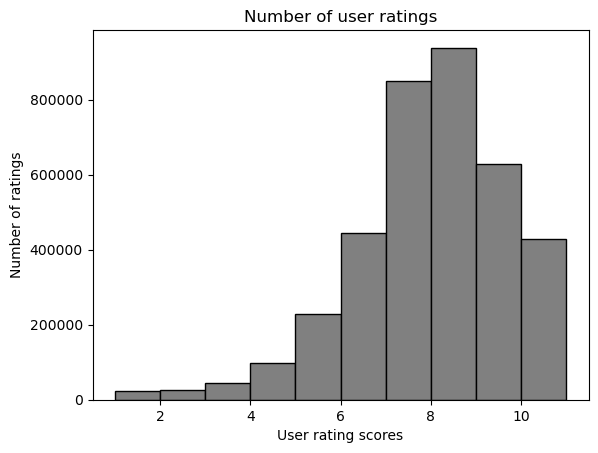

In [40]:
plt.hist(df_animelist.rating, bins=10, range = (1,11), edgecolor='black',color='gray')
plt.title('Number of user ratings')
plt.xlabel('User rating scores')
plt.ylabel('Number of ratings')
#plt.xticks(position='center')
plt.show()

In [41]:
#df_animelist['watched_episodes'].max()

In [42]:
#plt.hist(df_animelist.watched_episodes, bins=10,range=(1,11), edgecolor='black',color='black')
#plt.title('Number of user watched episodes')
#plt.xlabel('User watched episodes')
#plt.ylabel('Number of watched episodes')
#plt.xticks(position='center')
#plt.show()

## Train y Test

Dividimos en 70-30.  

In [43]:
#dividimos datos de Train
random.seed(42)
Train = df_animelist.sample(round(len(df_animelist)*0.7))

In [44]:
Train

,user_id,anime_id,rating
53579938,328279,9136,10
8723775,53436,32901,5
56031312,343420,9062,8
35549422,218164,10793,7
53956040,330662,6336,9
...,...,...,...
46753186,286696,20035,7
5267683,32290,8460,6
2885358,17767,23619,8
25750423,158609,36098,8


In [307]:
#Dividimos datos de test
Test = df_animelist[~df_animelist.isin(Train)].copy()
Test = Test.dropna()
Test

,user_id,anime_id,rating
977,7.0,431.0,9.0
980,7.0,5680.0,9.0
981,7.0,9617.0,10.0
985,7.0,1195.0,8.0
987,7.0,1840.0,8.0
...,...,...,...
57625726,353348.0,8424.0,8.0
57625729,353348.0,9617.0,10.0
57625733,353348.0,14027.0,7.0
57625735,353348.0,5081.0,10.0


In [308]:
Train.user_id.nunique()

19831

In [309]:
Train.anime_id.nunique()

15217

In [310]:
Test.user_id.nunique()

19377

Tenemos usuarios que aparezcan en el test y que no esten estén en el train?

In [311]:
Test[~Test.user_id.isin(Train.user_id.unique())].user_id.nunique()

169

Tenemos anime_id que esten en el test y no en el train?

In [312]:
Test[~Test.anime_id.isin(Train.anime_id.unique())].anime_id.nunique()

658

In [325]:
#Eliminamos aquellos anime_id del test que no estan en el train
Test = Test[~Test['anime_id'].isin(list(Test[~Test.anime_id.isin(Train.anime_id.unique())].anime_id))]

In [314]:
Test[~Test.anime_id.isin(Train.anime_id.unique())].anime_id.nunique()

0

Ahi tendremos que aplicar **cold start**

## Matriz de interacciones

In [315]:
Train

,user_id,anime_id,rating
53579938,328279,9136,10
8723775,53436,32901,5
56031312,343420,9062,8
35549422,218164,10793,7
53956040,330662,6336,9
...,...,...,...
46753186,286696,20035,7
5267683,32290,8460,6
2885358,17767,23619,8
25750423,158609,36098,8


In [316]:
#armamos la matriz de interacciones
interactions_matrix = Train.pivot(index="user_id", columns="anime_id", values="rating")
interactions_matrix.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,46491,47307,47398,47402,47403,47614,47616,47618,48177,48456
user_id,,,,,,,,,,,,,,,,,,,,,
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [317]:
#completamos NaN con 0
interactions_matrix = interactions_matrix.fillna(0)
interactions_matrix.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,46491,47307,47398,47402,47403,47614,47616,47618,48177,48456
user_id,,,,,,,,,,,,,,,,,,,,,
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [318]:
#Tamano de la matriz
interactions_matrix.shape

(19831, 15217)

transformamos la matriz a csr matrix (compressed sparse row)

In [319]:
interactions_matrix_csr = csr_matrix(interactions_matrix.values)
interactions_matrix_csr

<19831x15217 sparse matrix of type '<class 'numpy.float64'>'
	with 2599034 stored elements in Compressed Sparse Row format>

In [320]:
#Generamos un diccionario que tiene como keys el id de cada usuario y como valor el indice (número de fila en la matriz)
user_ids = list(interactions_matrix.index)
user_dict = {}
counter = 0 
for i in user_ids:
    user_dict[i] = counter
    counter += 1

In [321]:
user_dict

{7: 0,
 24: 1,
 28: 2,
 51: 3,
 83: 4,
 103: 5,
 128: 6,
 162: 7,
 222: 8,
 248: 9,
 258: 10,
 282: 11,
 291: 12,
 294: 13,
 335: 14,
 340: 15,
 347: 16,
 370: 17,
 378: 18,
 380: 19,
 392: 20,
 457: 21,
 459: 22,
 466: 23,
 477: 24,
 501: 25,
 502: 26,
 532: 27,
 541: 28,
 566: 29,
 568: 30,
 570: 31,
 585: 32,
 596: 33,
 658: 34,
 659: 35,
 666: 36,
 684: 37,
 690: 38,
 693: 39,
 696: 40,
 704: 41,
 711: 42,
 722: 43,
 750: 44,
 753: 45,
 755: 46,
 834: 47,
 842: 48,
 877: 49,
 924: 50,
 948: 51,
 958: 52,
 991: 53,
 996: 54,
 1006: 55,
 1018: 56,
 1020: 57,
 1032: 58,
 1045: 59,
 1070: 60,
 1080: 61,
 1094: 62,
 1101: 63,
 1120: 64,
 1191: 65,
 1192: 66,
 1205: 67,
 1209: 68,
 1257: 69,
 1267: 70,
 1287: 71,
 1316: 72,
 1364: 73,
 1375: 74,
 1393: 75,
 1429: 76,
 1437: 77,
 1464: 78,
 1508: 79,
 1556: 80,
 1577: 81,
 1605: 82,
 1617: 83,
 1678: 84,
 1696: 85,
 1697: 86,
 1747: 87,
 1757: 88,
 1805: 89,
 1825: 90,
 1856: 91,
 1858: 92,
 1859: 93,
 1860: 94,
 1864: 95,
 1879: 96,
 191

## Modelo

In [322]:
#cargamos el modelo de la libreria lightFM
model = LightFM(no_components=5, random_state=100, learning_rate=0.03, loss='warp')

In [323]:
%%time
model = model.fit(interactions_matrix_csr, epochs=20)

CPU times: user 34.8 s, sys: 43.9 ms, total: 34.8 s
Wall time: 34.8 s


Usamos gridsearch para encontrar los mejores parámetros

In [126]:
# Datos de entrenamiento (interactions_matrix_csr)
# (Asegúrate de tener tus datos de entrenamiento cargados y preparados adecuadamente)
#interactions_matrix_csr = ...

# Definir una cuadrícula de hiperparámetros
param_grid = {
    'no_components': [5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'loss': ['logistic', 'bpr', 'warp']
}

# Crear el modelo LightFM
#model = LightFM()

# Realizar una búsqueda de cuadrícula con validación cruzada
#grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
#grid_search.fit(interactions_matrix_csr)

# Obtener los mejores hiperparámetros y su rendimiento
#best_params = grid_search.best_params_
#best_score = grid_search.best_score_

#print("Mejores hiperparámetros:", best_params)
#print("Mejor AUC:", best_score)

Mejores hiperparámetros: {'learning_rate': 0.01, 'loss': 'logistic', 'no_components': 5}
Mejor AUC: nan


## Recomendaciones 

### Cold start 

Vamos a recomendar los 20 animes más populares a los usuarios que están en el set de Test pero no en el set de Train

In [179]:
Train.head()

,user_id,anime_id,rating
53579938,328279,9136,10
8723775,53436,32901,5
56031312,343420,9062,8
35549422,218164,10793,7
53956040,330662,6336,9


In [180]:
Train.groupby('anime_id', as_index=False).agg({'user_id':"nunique"})

,anime_id,user_id
0,1,3631
1,5,1526
2,6,2088
3,7,458
4,8,58
...,...,...
15212,47614,2
15213,47616,79
15214,47618,2
15215,48177,2


In [181]:
#Calculamos la cantidad de usuarios que vieron el mismo anime y ordenamos de mayor a menor para ver los 20 anime mas populares
popularity_df = Train.groupby("anime_id", as_index=False).agg({"user_id":"nunique"}).sort_values(by="user_id", ascending=False)
popularity_df.columns=["anime_id", "popularity"]
popularity_df.head()

,anime_id,popularity
1389,1535,8245
7249,16498,7549
6467,11757,7242
9801,30276,6319
4588,6547,6282


In [182]:
#Obtenemos una lista con los 20 contenidos mas populares
popular_content = popularity_df.anime_id.values[:20]
popular_content

array([ 1535, 16498, 11757, 30276,  6547,  1575,  4224,  5114, 19815,
         199, 22319,    20,  9253, 32281,  2904, 10620, 31964,   226,
       20507,  8074])

### Generamos 20 recomendaciones para cada usuario (anime_id)

* Vamos a filtrar los contenidos que los usuarios vieron anteriormente
* Si el usuario no está en el set de Train, le vamos a recomendar los 20 contenidos más populares

In [324]:
#definimos dict donde vamos a ir almacenando las recomendaciones
recomms_dict = {
    'user_id': [],
    'recomms': []
}

#obtenemos cantidad de usuarios y cantidad de items
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)
cold_start=0

#por cada usuario del dataset de test, generamos recomendaciones
for user in tqdm(Test.user_id.unique()):
    # Validar si el usuario se encuentra en la matriz de interacciones (interactions_matrix.index)
    if user in list(interactions_matrix.index):
      # Si el usuario esta en train, NO es cold start. Usamos el modelo para recomendar
      user_x = user_dict[user] #buscamos el indice del usuario en la matriz (transformamos id a indice)

      # Generar las predicciones para el usuario x
      preds = model.predict(user_ids=user_x, item_ids = item_ids)

      #Basándose en el ejemplo anterior, ordenar las predicciones de menor a mayor y quedarse con 50.
      scores = pd.Series(preds)
      scores.index = interactions_matrix.columns
      scores = list(pd.Series(scores.sort_values(ascending=False).index))[:50]

      # Obtener listado de contenidos vistos anteriormente por el usuario (en el set de train)
      watched_contents = Train[Train.user_id == user].anime_id.unique()

      #Filtrar contenidos ya vistos y quedarse con los primeros 20
      recomms = [x for x in scores if x not in watched_contents][:20]

      # Guardamos las recomendaciones en el diccionario
      recomms_dict['user_id'].append(user)
      recomms_dict['recomms'].append(recomms)
    
    # En este else trataremos a los usuarios que no están en la matriz (cold start)
    else:
      recomms_dict['user_id'].append(user)
      # Les recomendamos contenido popular
      recomms_dict['recomms'].append(popular_content)
      cold_start=cold_start+1

  0%|          | 0/19377 [00:00<?, ?it/s]

100%|██████████| 19377/19377 [02:57<00:00, 109.38it/s]


In [326]:
recomms_df = pd.DataFrame(recomms_dict)
recomms_df.sample(10)

,user_id,recomms
15680,285974.0,"[199, 1575, 2904, 431, 20, 164, 226, 6547, 223..."
17392,317389.0,"[1535, 199, 16498, 164, 20, 11757, 4224, 523, ..."
12477,228941.0,"[19815, 31043, 10620, 1575, 12189, 5081, 31964..."
10977,201936.0,"[3457, 4898, 20, 199, 1575, 9919, 4752, 5114, ..."
17671,322674.0,"[33486, 31964, 30276, 30831, 22199, 23755, 281..."
15079,275110.0,"[226, 121, 1575, 849, 59, 853, 317, 71, 355, 1..."
577,10197.0,"[1535, 9989, 15809, 2001, 2167, 11111, 31043, ..."
1595,29445.0,"[1535, 1575, 121, 226, 20, 2904, 431, 3457, 16..."
17595,321106.0,"[1535, 16498, 11757, 30276, 6547, 1575, 4224, ..."
6785,125088.0,"[1195, 1575, 6547, 2167, 355, 8074, 849, 1840,..."


A cuantos usuarios se le recomendaron las 20 series anime mas populares? 

In [327]:
cold_start

169

### Generamos 20 recomendaciones para cada usuario (anime_name)

Vamos a ver el nombre de la serie anime para cada anime_id recomendado 

In [328]:
metadata = pd.read_csv(f'{path}/anime.csv')
metadata.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [329]:
#armamos un diccionario donde la key es el anime_id y el valor el el anime_name
dic_anime = dict(zip(metadata['MAL_ID'],metadata['Name']))
dic_anime

{1: 'Cowboy Bebop',
 5: 'Cowboy Bebop: Tengoku no Tobira',
 6: 'Trigun',
 7: 'Witch Hunter Robin',
 8: 'Bouken Ou Beet',
 15: 'Eyeshield 21',
 16: 'Hachimitsu to Clover',
 17: 'Hungry Heart: Wild Striker',
 18: 'Initial D Fourth Stage',
 19: 'Monster',
 20: 'Naruto',
 21: 'One Piece',
 22: 'Tennis no Ouji-sama',
 23: 'Ring ni Kakero 1',
 24: 'School Rumble',
 25: 'Sunabouzu',
 26: 'Texhnolyze',
 27: 'Trinity Blood',
 28: 'Yakitate!! Japan',
 29: 'Zipang',
 30: 'Neon Genesis Evangelion',
 31: 'Neon Genesis Evangelion: Death & Rebirth',
 32: 'Neon Genesis Evangelion: The End of Evangelion',
 33: 'Kenpuu Denki Berserk',
 43: 'Koukaku Kidoutai',
 44: 'Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen',
 45: 'Rurouni Kenshin: Meiji Kenkaku Romantan',
 46: 'Rurouni Kenshin: Meiji Kenkaku Romantan - Ishinshishi e no Chinkonka',
 47: 'Akira',
 48: '.hack//Sign',
 49: 'Aa! Megami-sama!',
 50: 'Aa! Megami-sama! (TV)',
 51: 'Tenshi Kinryouku',
 52: 'Kidou Tenshi Angelic Layer',
 53: 'Ai Yori 

In [330]:
#Generamos una funcion para obtener una nueva columna con el anime_name para cada anime_id
def anime_name (row,dic_anime=dic_anime):
    return([dic_anime[recom_id] for recom_id in row])    

In [331]:
recomms_df['anime_name'] = recomms_df.recomms.apply(anime_name)

In [332]:
recomms_df.sample(15)

,user_id,recomms,anime_name
211,3974.0,"[16498, 19815, 32281, 22319, 31240, 1535, 3348...","[Shingeki no Kyojin, No Game No Life, Kimi no ..."
12272,224791.0,"[1535, 11757, 6547, 4224, 16498, 1575, 5114, 2...","[Death Note, Sword Art Online, Angel Beats!, T..."
17504,319571.0,"[1195, 6547, 9041, 8074, 4224, 2993, 3712, 155...","[Zero no Tsukaima, Angel Beats!, IS: Infinite ..."
16757,306114.0,"[9919, 6547, 7054, 8074, 14227, 11111, 6746, 9...","[Ao no Exorcist, Angel Beats!, Kaichou wa Maid..."
8989,166089.0,"[16498, 22319, 31240, 15809, 22199, 28121, 116...","[Shingeki no Kyojin, Tokyo Ghoul, Re:Zero kara..."
7579,140400.0,"[1535, 199, 431, 164, 1575, 226, 523, 5114, 20...","[Death Note, Sen to Chihiro no Kamikakushi, Ho..."
7825,144754.0,"[11757, 9989, 14227, 19815, 32281, 13601, 9253...","[Sword Art Online, Ano Hi Mita Hana no Namae w..."
13017,238770.0,"[1535, 16498, 6547, 1575, 2904, 30276, 11111, ...","[Death Note, Shingeki no Kyojin, Angel Beats!,..."
16126,294302.0,"[853, 4898, 20, 3457, 6707, 5114, 1575, 4814, ...","[Ouran Koukou Host Club, Kuroshitsuji, Naruto,..."
8356,155160.0,"[1535, 16498, 30276, 32281, 31964, 11757, 2231...","[Death Note, Shingeki no Kyojin, One Punch Man..."


In [333]:
def anime_name_ (row,dic_anime=dic_anime):
    return(dic_anime[row])    

In [334]:
#vemos los nombres de los anime mas populares
popularity_df['anime_name'] = popularity_df.anime_id.apply(anime_name_)

In [335]:
popularity_df

,anime_id,popularity,anime_name
1389,1535,8245,Death Note
7249,16498,7549,Shingeki no Kyojin
6467,11757,7242,Sword Art Online
9801,30276,6319,One Punch Man
4588,6547,6282,Angel Beats!
...,...,...,...
13676,38781,1,Violence Voyager
7945,20183,1,Manga Ijin Monogatari
7944,20177,1,Gin no Otoko
11745,34980,1,Fin-tan


In [336]:
popularity_df.head(20)

,anime_id,popularity,anime_name
1389,1535,8245,Death Note
7249,16498,7549,Shingeki no Kyojin
6467,11757,7242,Sword Art Online
9801,30276,6319,One Punch Man
4588,6547,6282,Angel Beats!
1427,1575,6096,Code Geass: Hangyaku no Lelouch
3545,4224,5981,Toradora!
3947,5114,5952,Fullmetal Alchemist: Brotherhood
7862,19815,5843,No Game No Life
175,199,5820,Sen to Chihiro no Kamikakushi


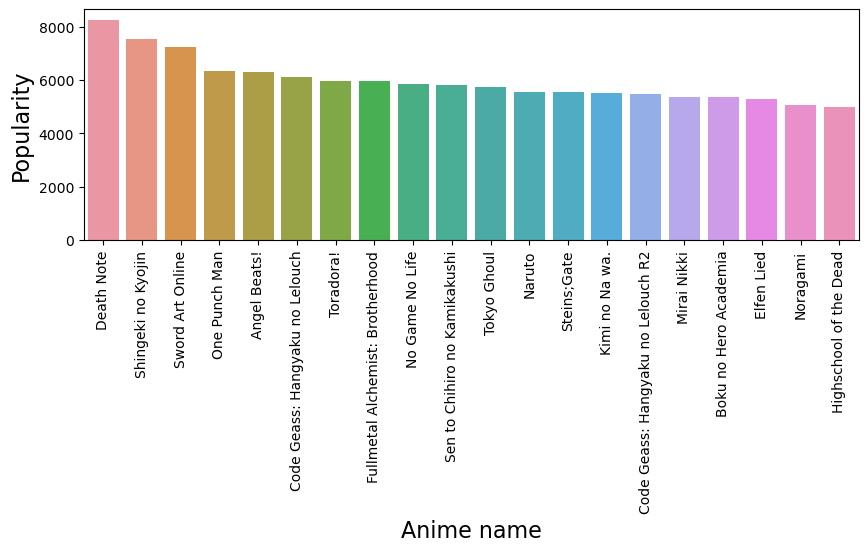

In [337]:
plt.figure(figsize=(10,3))
sns.barplot(x='anime_name', y='popularity', data=popularity_df.head(20)) #,order=neg['reviews'].value_counts().index
plt.xlabel('Anime name',fontsize=16)
plt.ylabel('Popularity',fontsize=16)
plt.xticks(rotation=90)
#plt.tight_layout()
plt.show()

In [338]:
#recomms_df.to_csv('recomms.csv')

## Métricas

In [339]:
recomms_df

,user_id,recomms,anime_name
0,7.0,"[4224, 1535, 1575, 16498, 2167, 9919, 1195, 29...","[Toradora!, Death Note, Code Geass: Hangyaku n..."
1,24.0,"[3457, 853, 1535, 120, 4752, 20, 121, 4898, 24...","[Vampire Knight, Ouran Koukou Host Club, Death..."
2,28.0,"[1575, 121, 5114, 30, 164, 1, 4224, 849, 223, ...","[Code Geass: Hangyaku no Lelouch, Fullmetal Al..."
3,51.0,"[1535, 20, 16498, 431, 4898, 2904, 3457, 121, ...","[Death Note, Naruto, Shingeki no Kyojin, Howl ..."
4,83.0,"[21881, 31964, 32281, 27899, 11617, 14813, 322...","[Sword Art Online II, Boku no Hero Academia, K..."
...,...,...,...
19372,353313.0,"[1535, 16498, 4224, 6547, 1575, 20, 5114, 8074...","[Death Note, Shingeki no Kyojin, Toradora!, An..."
19373,353334.0,"[16498, 1535, 9919, 22319, 1575, 11111, 30276,...","[Shingeki no Kyojin, Death Note, Ao no Exorcis..."
19374,353335.0,"[31964, 32281, 9919, 20583, 5114, 23273, 30503...","[Boku no Hero Academia, Kimi no Na wa., Ao no ..."
19375,353348.0,"[1535, 1575, 226, 11757, 2904, 8074, 16498, 21...","[Death Note, Code Geass: Hangyaku no Lelouch, ..."


In [340]:
Test

,user_id,anime_id,rating
977,7.0,431.0,9.0
980,7.0,5680.0,9.0
981,7.0,9617.0,10.0
985,7.0,1195.0,8.0
987,7.0,1840.0,8.0
...,...,...,...
57625726,353348.0,8424.0,8.0
57625729,353348.0,9617.0,10.0
57625733,353348.0,14027.0,7.0
57625735,353348.0,5081.0,10.0


In [341]:
Test.user_id.nunique()

19377

In [342]:
Test.anime_id.nunique()

12844

In [343]:
Train.anime_id.nunique()

15217

In [344]:
Train

,user_id,anime_id,rating
53579938,328279,9136,10
8723775,53436,32901,5
56031312,343420,9062,8
35549422,218164,10793,7
53956040,330662,6336,9
...,...,...,...
46753186,286696,20035,7
5267683,32290,8460,6
2885358,17767,23619,8
25750423,158609,36098,8


Armamos el listado ideal de items para cada usuario contra el que vamos a comparar nuestras recomendaciones

In [345]:
ideal_recomms = Test.sort_values(by=["user_id", "rating"], ascending=False)\
                  .groupby(["user_id"], as_index=False)\
                  .agg({"anime_id": "unique"})       
ideal_recomms

,user_id,anime_id
0,7.0,"[9617.0, 13759.0, 431.0, 5680.0, 226.0, 2167.0..."
1,24.0,[740.0]
2,28.0,"[3457.0, 223.0, 1575.0, 465.0, 4026.0, 3455.0,..."
3,51.0,"[2904.0, 1535.0, 11123.0, 31964.0, 120.0, 164...."
4,83.0,"[37521.0, 32282.0, 24405.0, 9253.0, 1604.0, 38..."
...,...,...
19372,353313.0,"[25183.0, 8676.0, 35507.0, 23755.0, 1575.0, 11..."
19373,353334.0,"[16498.0, 199.0, 2890.0, 6702.0, 1535.0, 20.0,..."
19374,353335.0,"[37779.0, 1564.0, 5355.0, 6634.0, 25777.0, 578..."
19375,353348.0,"[9989.0, 10020.0, 9617.0, 5081.0, 8424.0, 1402..."


Ahora vamos a medir MAP

Unimos en un mismo dataframe las recomendaciones nuestras con el set ideal

In [346]:
df_map = ideal_recomms.merge(recomms_df, how="left", left_on="user_id", right_on="user_id")[["user_id", "anime_id", "recomms"]]
df_map.columns = ["user_id", "ideal", "recomms"]
df_map.head(15)

,user_id,ideal,recomms
0,7.0,"[9617.0, 13759.0, 431.0, 5680.0, 226.0, 2167.0...","[4224, 1535, 1575, 16498, 2167, 9919, 1195, 29..."
1,24.0,[740.0],"[3457, 853, 1535, 120, 4752, 20, 121, 4898, 24..."
2,28.0,"[3457.0, 223.0, 1575.0, 465.0, 4026.0, 3455.0,...","[1575, 121, 5114, 30, 164, 1, 4224, 849, 223, ..."
3,51.0,"[2904.0, 1535.0, 11123.0, 31964.0, 120.0, 164....","[1535, 20, 16498, 431, 4898, 2904, 3457, 121, ..."
4,83.0,"[37521.0, 32282.0, 24405.0, 9253.0, 1604.0, 38...","[21881, 31964, 32281, 27899, 11617, 14813, 322..."
5,103.0,"[22319.0, 16742.0, 15583.0, 3092.0, 22961.0, 2...","[1535, 20, 11757, 1575, 4224, 199, 5114, 2904,..."
6,128.0,"[2001.0, 1842.0, 627.0, 267.0, 2313.0, 1210.0,...","[199, 226, 853, 164, 2025, 205, 431, 317, 430,..."
7,162.0,"[21097.0, 2904.0, 1735.0, 199.0, 16498.0, 2748...","[16498, 31964, 1535, 33486, 22319, 38000, 3104..."
8,222.0,"[30484.0, 32729.0, 36563.0, 20.0, 33489.0, 173...","[33486, 30831, 36456, 38000, 32937, 35849, 341..."
9,248.0,"[523.0, 851.0, 223.0, 32281.0, 7791.0, 268.0, ...","[32281, 25777, 28851, 31240, 38000, 37779, 198..."


In [347]:
df_map.iloc[3,:]

user_id                                                 51.0
ideal      [2904.0, 1535.0, 11123.0, 31964.0, 120.0, 164....
recomms    [1535, 20, 16498, 431, 4898, 2904, 3457, 121, ...
Name: 3, dtype: object

In [348]:
aps = [] # lista vacía para ir almacenando la AP de cada recomendación

for pred, label in df_map[["ideal", "recomms"]].values:
  n = len(pred) # cantidad de elementos recomendados
  arange = np.arange(n, dtype=np.int32) + 1. # indexamos en base 1 
  rel_k = np.in1d(pred[:n], label) # lista de booleanos que indican la relevancia de cada ítem
  tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # lista con el contador de verdaderos positivos
  denom = arange[rel_k] # posiciones donde se encuentran los ítems relantes
  ap = (tp / denom).sum() / len(label) # average precision
  aps.append(ap)

In [349]:
MAP = np.mean(aps)
print(f'mean average precision = {round(MAP, 5)}')

mean average precision = 0.09224


### Otras métricas

### MAP

In [350]:
test_data = df_map.copy()
import pandas as pd
import numpy as np

def average_precision(ideal, recomms):
    num_hits = 0
    sum_precision = 0.0

    for i, item in enumerate(recomms):
        if item in ideal:
            num_hits += 1
            precision = num_hits / (i + 1)
            sum_precision += precision

    if not ideal.any():
        return 0

    return sum_precision / len(ideal)

def mean_average_precision(test_data):
    map_sum = 0.0
    num_users = len(test_data)

    for _, row in test_data.iterrows():
        ideal = row['ideal']
        recomms = row['recomms']
        ap = average_precision(ideal, recomms)
        map_sum += ap

    return map_sum / num_users

# Suponiendo que tienes un DataFrame llamado "df_map" con las columnas 'user_id', 'ideal' y 'recomms'.
map_score = mean_average_precision(test_data)
print(f"Mean Average Precision (MAP): {map_score}")

Mean Average Precision (MAP): 0.082643866965367


### NDCG@10

In [351]:
results = df_map.copy()
def dcg_at_k(ideal, recomms, k):
    k = min(len(recomms), k)  # Asegurarse de que k no sea mayor que el tamaño de la lista de recomendaciones.
    dcg = 0.0
    
    for i in range(k):
        series_id = recomms[i]
        if series_id in ideal:
            relevance = 1.0
        else:
            relevance = 0.0
        
        dcg += (2**relevance - 1) / np.log2(i + 2)
    
    return dcg

def ndcg_at_k(ideal, recomms, k):
    k = min(min(len(recomms), len(ideal)), k)  # Asegurarse de que k no sea mayor que el tamaño de ninguna de las listas.
    dcg_max = dcg_at_k(ideal, ideal, k)
    if dcg_max == 0:
        return 0.0
    
    return dcg_at_k(ideal, recomms, k) / dcg_max

def mean_ndcg(results, k):
    ndcg_list = []
    
    for _, row in results.iterrows():
        ndcg = ndcg_at_k(row['ideal'], row['recomms'], k)
        ndcg_list.append(ndcg)
        
    return np.mean(ndcg_list)

# Llamar a la función para calcular el NDCG con k=10, por ejemplo
k = 20
ndcg_score = mean_ndcg(results, k)

print(f"Mean NDCG@{k}: {ndcg_score}")


Mean NDCG@20: 0.3506897194312744


In [352]:
def ndcg_at_k(pred, label, k):
    n = min(k, len(pred))  # Consideramos hasta los primeros 'k' elementos
    arange = np.arange(n, dtype=np.int32) + 1.  # Indexamos en base 1
    rel_k = np.in1d(pred[:n], label)  # Lista de booleanos que indican la relevancia de cada ítem
    dcg = (2 ** rel_k - 1) / np.log2(arange + 1)  # Discounted Cumulative Gain
    idcg = (2 ** np.ones_like(rel_k) - 1) / np.log2(arange + 1)  # Ideal Discounted Cumulative Gain
    ndcg = (dcg / idcg).sum() / len(label)  # Normalized Discounted Cumulative Gain
    return ndcg


k = 20  # Consideramos los primeros 20 elementos para calcular NDCG@5

ndcgs = []  # Lista vacía para almacenar el NDCG de cada recomendación

for pred, label in df_map[["recomms", "ideal"]].values:
    ndcg = ndcg_at_k(pred, label, k)
    ndcgs.append(ndcg)

mean_ndcg = np.mean(ndcgs)
print("Mean NDCG@{}: {:.4f}".format(k, mean_ndcg))

Mean NDCG@20: 0.1605


### Hits@20

In [353]:
test_data = df_map.copy()
def hits_at_k(ideal, recomms, k):
    # Truncar las listas a los primeros k elementos
    ideal = ideal[:k]
    recomms = recomms[:k]

    # Calcular los ítems acertados
    hits = [1 if item in ideal else 0 for item in recomms]

    # Calcular la precisión (Hits@K)
    precision_at_k = sum(hits) / k

    return precision_at_k

def mean_hits_at_k(test_data, k):
    hits_sum = 0.0
    num_users = len(test_data)

    for _, row in test_data.iterrows():
        ideal = row['ideal']
        recomms = row['recomms']
        hits = hits_at_k(ideal, recomms, k)
        hits_sum += hits

    return hits_sum / num_users

# Suponiendo que tienes un DataFrame llamado "df_map" con las columnas 'user_id', 'ideal' y 'recomms'.
k = 20  # Número de elementos a considerar para el cálculo del Hits@K
hits_score = mean_hits_at_k(df_map, k)
print(f"Hits@{k}: {hits_score}")

Hits@20: 0.15522010631160793
